SPY       97.701076
GOOGL    273.565857
IBM      108.293227
dtype: float64
SPY       98.376125
GOOGL    282.497498
IBM      104.043328
dtype: float64
SPY      16.540641
GOOGL    47.748581
IBM      27.136946
dtype: float64
Kurtosis (positive denotes fat tail)= 3.40860333552049
alpha_GOOGL= 0.0004023144664888968
beta_GOOGL= 0.9002277291971397
            SPY     GOOGL       IBM
SPY    1.000000  0.672089  0.725294
GOOGL  0.672089  1.000000  0.515052
IBM    0.725294  0.515052  1.000000
Sharpe ratio(s) =
 SPY      0.723004
GOOGL    0.851779
IBM      1.107903
dtype: float64


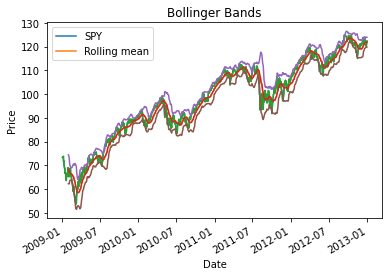

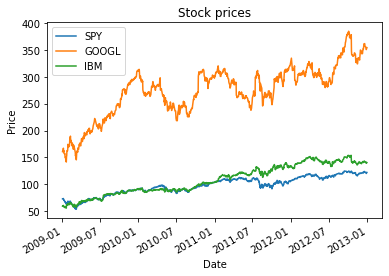

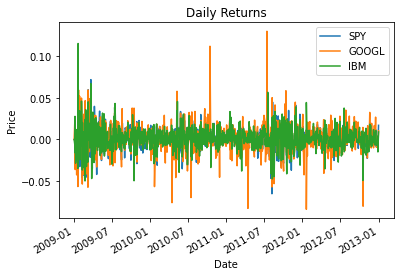

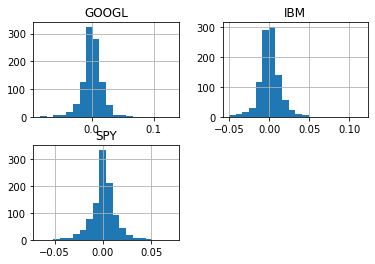

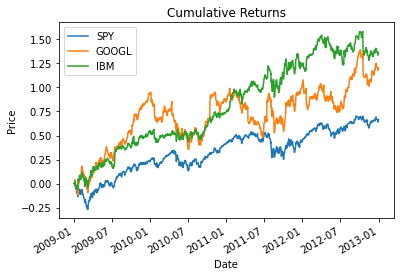

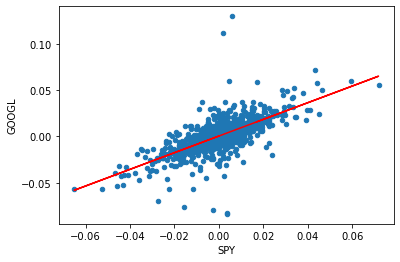

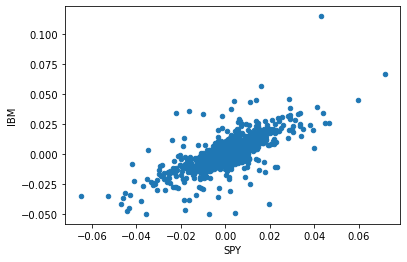

In [19]:
"""Utility functions"""

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_selected(df, columns, start_index, end_index):
    """Plot the desired columns over index values in the given range."""
    df1=df.loc[start_index:end_index,columns]
    plot_data(df1,'Selected data')

def symbol_to_path(symbol, base_dir="data"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'SPY' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'SPY')

    for symbol in symbols:
        # TODO: Read and join data for each symbol
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date', parse_dates=True, usecols=['Date','Adj Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df=df.join(df_temp)  # use default how='left'
        if symbol == 'SPY':  # drop dates SPY did not trade
            df=df.dropna(subset=['SPY'])
    return df

#def normalise_data(df):
#    #Normalising by stock value on first row
#    df1 = df.div(df.iloc[0])
#    df1.plot()

def test_run():
    # Define a date range
#    dates = pd.date_range('2010-01-01', '2010-12-31')
    dates = pd.date_range('2009-01-01', '2012-12-31')

    # Choose stock symbols to read
#    symbols = ['GOOGL','IBM', 'GLD', 'FAKE1', 'FAKE2']
#    symbols = ['FAKE1', 'FAKE2']
    symbols = ['GOOGL','IBM']
    
    # Get stock data
    df = get_data(symbols, dates)
#    print(df)

    # Fill empty data forwards first then backwards (so no peaking into the future)
    df.fillna(method='ffill',inplace=True)
    df.fillna(method='bfill',inplace=True)
    
#    plot_data(df,'Stock prices')

    # Compute global statistics for each stock
    print(df.mean())
    print(df.median())
    print(df.std())
    
    # Compute rolling mean using a 20-day window
    rm_SPY = df['SPY'].rolling(window=20).mean()
    
    # Plot SPY data, retain matplotlib axis object
    ax = df['SPY'].plot(title='SPY rolling mean',label='SPY')
    
    # Add rolling mean to same plot
    rm_SPY.plot(label='Rolling mean', ax=ax)
    
    # Add axis labels and legend
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')
    
    # Compute Bollinger Bands
    # 1. Compute rolling mean
    rm_SPY = get_rolling_mean(df['SPY'], window=20)

    # 2. Compute rolling standard deviation
    rstd_SPY = get_rolling_std(df['SPY'], window=20)

    # 3. Compute upper and lower bands
    upper_band, lower_band = get_bollinger_bands(rm_SPY, rstd_SPY) 
    
    # Plot raw SPY values, rolling mean and Bollinger Bands
    ax = df['SPY'].plot(title="Bollinger Bands", label='SPY')
    rm_SPY.plot(label='Rolling mean', ax=ax)
    upper_band.plot(label='upper band', ax=ax)
    lower_band.plot(label='lower band', ax=ax)
    
    # plot daily data
    plot_data(df,'Stock prices')
    
    # Compute and plot daily returns
    daily_returns = compute_daily_returns(df) 
    plot_data(daily_returns, title='Daily Returns')
    
    # Plot histogram
    daily_returns.hist(bins=20)
    

    # NOTHING WORKS ! To plot several histograms on the same chart  NOTHING WORKS
#    plt.hist(daily_returns['SPY'])
#    plt.hist(daily_returns['GOOGL'],bins=10)
#    daily_returns['GOOGL'].hist(bins=20)
#    plt.show()
#    plt.legend(loc='upper right')
    
    # Get mean and standard deviation
    mean = daily_returns['SPY'].mean()
    std = daily_returns['SPY'].std()
    kurtosis = daily_returns['SPY'].kurtosis()
    
    print('Kurtosis (positive denotes fat tail)=', kurtosis)
    
    plt.axvline(mean,color='w',linestyle='dashed',linewidth=2)
    plt.axvline(std,color='r',linestyle='dashed',linewidth=2)
    plt.axvline(-std,color='r',linestyle='dashed',linewidth=2)
        
    # Compute and plot cumulative returns
    cumulative_returns = compute_cumulative_returns(df) 
    plot_data(cumulative_returns, title='Cumulative Returns')
    
    
    # Scatterplot SPY vs GOOGL
    daily_returns.plot(kind='scatter',x='SPY',y='GOOGL')
    beta_GOOGL,alpha_GOOGL = np.polyfit(daily_returns['SPY'],daily_returns['GOOGL'],1)
    plt.plot(daily_returns['SPY'],beta_GOOGL*daily_returns['SPY']+alpha_GOOGL, '-',color='r')
    print('alpha_GOOGL=',alpha_GOOGL)
    print('beta_GOOGL=',beta_GOOGL)
    
    #  Calculate correlation coefficient
    print(daily_returns.corr(method='pearson'))
    
    #  Calculate Sharpe ratio
    sharpe = compute_sharpe_ratio(daily_returns, 0, 252)
    print('Sharpe ratio =\n', sharpe)
    
    # Scatterplot SPY vs IBM
    daily_returns.plot(kind='scatter',x='SPY',y='IBM')
    
def get_rolling_mean(values, window):
    """Return rolling mean of given values, using specified window size."""
    return values.rolling(window=window).mean()


def get_rolling_std(values, window):
    """Return rolling standard deviation of given values, using specified window size."""
    return values.rolling(window=window).std()


def get_bollinger_bands(rm, rstd):
    """Return upper and lower Bollinger Bands."""
    upper_band = rm + (2 * rstd)
    lower_band = rm - (2 * rstd)
    return upper_band, lower_band

def compute_daily_returns(df):
    daily_returns = df.copy() # copy givge dataframe to match size and column names
    #daily_returns[1:] = ( df[1:] / df[:-1].values ) - 1.0
    daily_returns = ( df / df.shift(1)) -1  # much easier with pandas!
    daily_returns.iloc[0, :] = 0.0 # set daily returns for row 0 to zero
    return daily_returns

def compute_cumulative_returns(df):
    cumulative_returns = df.copy() # copy givge dataframe to match size and column names
    cumulative_returns = df.div(df.iloc[0]) - 1.0   #using Pandas
    cumulative_returns.iloc[0, :] = 0.0 # set cumulative returns for row 0 to zero
    return cumulative_returns

def compute_sharpe_ratio(daily_ret,daily_rf,samples_per_year):
    # Return Sharpe ratio 
    mean_dt = daily_ret.mean()
    std_dt = daily_ret.std()
    sharpe = math.sqrt(samples_per_year) * ( (mean_dt - daily_rf) / std_dt )
    return sharpe

def plot_data(df,title):
    # Plot stock prices'''
    ax=df.plot(title=title,fontsize=10)
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Price',fontsize=10)
#    df.plot()
#    plt.show()
    
if __name__ == "__main__":
    test_run()


